### Red Bipartita y Gráficos de Coocurrencia

Este notebook contiene una explicación detallada y código para analizar datos de explotación de minerales en Colombia. Se generan redes bipartitas y de coocurrencia entre municipios y recursos naturales. Los pasos están divididos lógicamente y acompañados de explicaciones.


In [6]:
# Importamos las bibliotecas necesarias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

### 1. Carga de Datos

Primero, cargamos los datos desde un archivo CSV.

Este paso nos da un `DataFrame` con información sobre municipios, recursos naturales, cantidad producida y regalías.


In [7]:
def load_data(file_path):
    return pd.read_csv(file_path)

# Ejemplo: cargar datos desde un archivo (reemplazar con la ruta adecuada)
df = load_data("../datos/raw/Volúmen de explotación de minerales en Colombia.csv")
df.head()

,cod_municipio,municipio,cod_departamento,departamento,recurso_natural,nombre_proyecto,anio_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion
0,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS,PRODUCTORES,2018,TRIMESTRE 4,TONELADAS,REGALIAS,614258,0
1,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS CERAMICAS,PRODUCTORES,2014,TRIMESTRE 4,TONELADAS,REGALIAS,2036781,14381
2,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,TRIMESTRE 1,TONELADAS,REGALIAS,836927,16308
3,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2019,TRIMESTRE 1,TONELADAS,REGALIAS,5763839,33348
4,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2022,TRIMESTRE 1,TONELADAS,REGALIAS,7187998,28540


In [8]:
df["unidad_medida"].unique()

array(['TONELADAS', 'METROS CUBICOS', 'GRAMOS', 'KILOGRAMOS', 'QUILATES',
       'LIBRAS'], dtype=object)

In [9]:
def convertir_a_toneladas(row):
    conversiones = {
        'TONELADAS': 1,
        'METROS CUBICOS': 1.5,  # Ejemplo de conversión, ajustar según sea necesario
        'GRAMOS': 1e-6,
        'KILOGRAMOS': 1e-3,
        'QUILATES': 2e-7,  # Ejemplo de conversión, ajustar según sea necesario
        'LIBRAS': 0.000453592
    }
    return row['cantidad_produccion'] * conversiones[row['unidad_medida']]

df['cantidad_produccion_toneladas'] = df.apply(convertir_a_toneladas, axis=1)
df.head()

,cod_municipio,municipio,cod_departamento,departamento,recurso_natural,nombre_proyecto,anio_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion,cantidad_produccion_toneladas
0,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS,PRODUCTORES,2018,TRIMESTRE 4,TONELADAS,REGALIAS,614258,0,0.0
1,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS CERAMICAS,PRODUCTORES,2014,TRIMESTRE 4,TONELADAS,REGALIAS,2036781,14381,14381.0
2,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,TRIMESTRE 1,TONELADAS,REGALIAS,836927,16308,16308.0
3,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2019,TRIMESTRE 1,TONELADAS,REGALIAS,5763839,33348,33348.0
4,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2022,TRIMESTRE 1,TONELADAS,REGALIAS,7187998,28540,28540.0


In [10]:
# Quitar las filas con "METROS CUBICOS" en la columna "unidad_medida" porque no se tiene la densidad para la conversión
df = df[df['unidad_medida'] != 'METROS CUBICOS']
df.head()

,cod_municipio,municipio,cod_departamento,departamento,recurso_natural,nombre_proyecto,anio_produccion,trimestre,unidad_medida,tipo_contraprestacion,valor_contraprestacion,cantidad_produccion,cantidad_produccion_toneladas
0,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS,PRODUCTORES,2018,TRIMESTRE 4,TONELADAS,REGALIAS,614258,0,0.0
1,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS CERAMICAS,PRODUCTORES,2014,TRIMESTRE 4,TONELADAS,REGALIAS,2036781,14381,14381.0
2,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,TRIMESTRE 1,TONELADAS,REGALIAS,836927,16308,16308.0
3,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2019,TRIMESTRE 1,TONELADAS,REGALIAS,5763839,33348,33348.0
4,5001,MEDELLÍN,5,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2022,TRIMESTRE 1,TONELADAS,REGALIAS,7187998,28540,28540.0


### 2. Creación de la Red Bipartita

Construimos una red bipartita donde:
- Un conjunto de nodos representa municipios.
- El otro conjunto representa recursos naturales.
- Las aristas representan conexiones entre municipios y recursos.


In [11]:
def create_bipartite_graph(df):
    B = nx.Graph()
    for _, row in df.iterrows():
        municipio = row['municipio']
        recurso = row['recurso_natural']
        regalias = row['valor_contraprestacion']
        toneladas = row['cantidad_produccion_toneladas']

        B.add_node(municipio, bipartite=0, tipo='municipio', regalias=regalias, toneladas=toneladas)
        B.add_node(recurso, bipartite=1, tipo='recurso')
        B.add_edge(municipio, recurso)
    return B

B = create_bipartite_graph(df)

### 3. Análisis de la Red Bipartita

Podemos identificar los municipios más destacados según sus atributos:
- Regalías (`regalias`).
- Toneladas producidas (`toneladas`).


In [12]:
def get_top_municipalities(B, attribute, n=10):
    municipios = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
    return sorted(municipios, key=lambda x: B.nodes[x][attribute], reverse=True)[:n]

top_municipios_regalias = get_top_municipalities(B, 'regalias')
top_municipios_toneladas = get_top_municipalities(B, 'toneladas')
print("Top 10 Municipios por Regalías:", top_municipios_regalias)
print("Top 10 Municipios por Toneladas:", top_municipios_toneladas)

Top 10 Municipios por Regalías: ['BECERRIL', 'HATONUEVO', 'CHIRIGUANÁ', 'GUACHETÁ', 'SOCOTÁ', 'CUCUNUBÁ', 'BOCHALEMA', 'TASCO', 'MONGUA', 'SATIVASUR']
Top 10 Municipios por Toneladas: ['BECERRIL', 'TIBASOSA', 'HATONUEVO', 'CHIRIGUANÁ', 'PAICOL', 'GUACHETÁ', 'SOACHA', 'ARROYOHONDO', 'BOSCONIA', 'SOCOTÁ']


### 4. Visualización

#### 4.1 Gráficos de Barras
Mostramos los municipios principales en términos de regalías y toneladas.


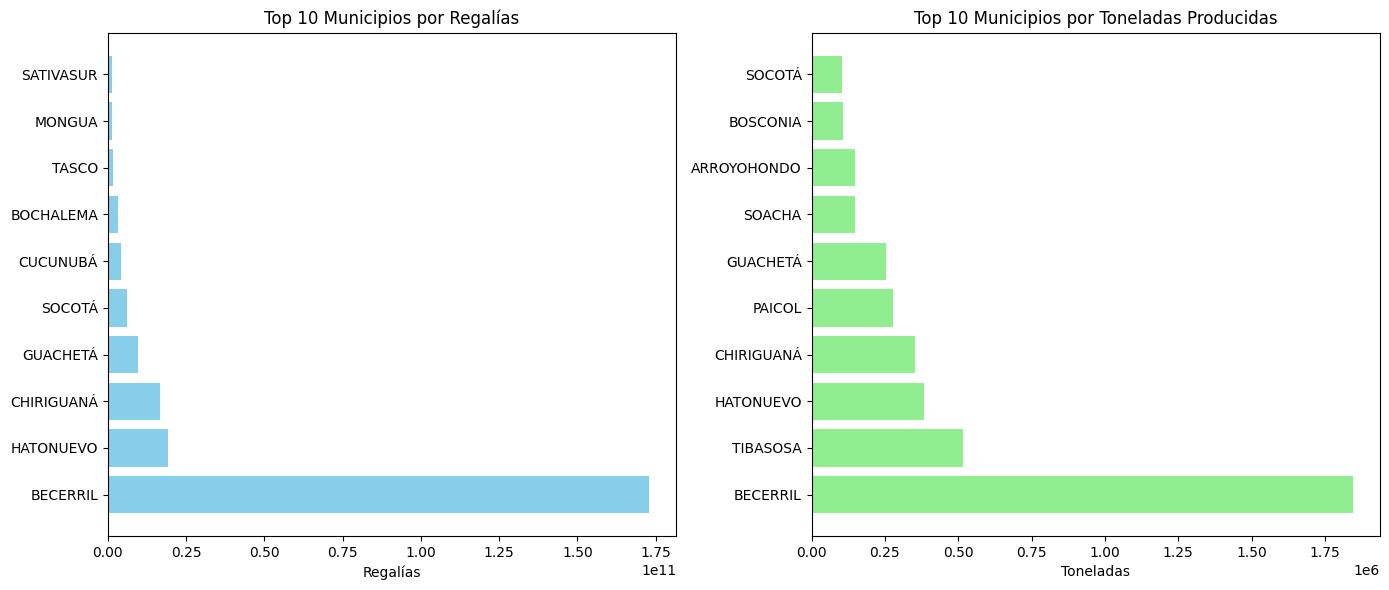

In [13]:
def plot_top_municipalities(B, top_municipios_regalias, top_municipios_toneladas):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    regalias_values = [B.nodes[municipio]['regalias'] for municipio in top_municipios_regalias]
    axes[0].barh(top_municipios_regalias, regalias_values, color='skyblue')
    axes[0].set_title('Top 10 Municipios por Regalías')
    axes[0].set_xlabel('Regalías')

    toneladas_values = [B.nodes[municipio]['toneladas'] for municipio in top_municipios_toneladas]
    axes[1].barh(top_municipios_toneladas, toneladas_values, color='lightgreen')
    axes[1].set_title('Top 10 Municipios por Toneladas Producidas')
    axes[1].set_xlabel('Toneladas')

    plt.tight_layout()
    plt.show()

plot_top_municipalities(B, top_municipios_regalias, top_municipios_toneladas)

#### 4.2 Visualización de la Red Bipartita
Representamos gráficamente la red bipartita.

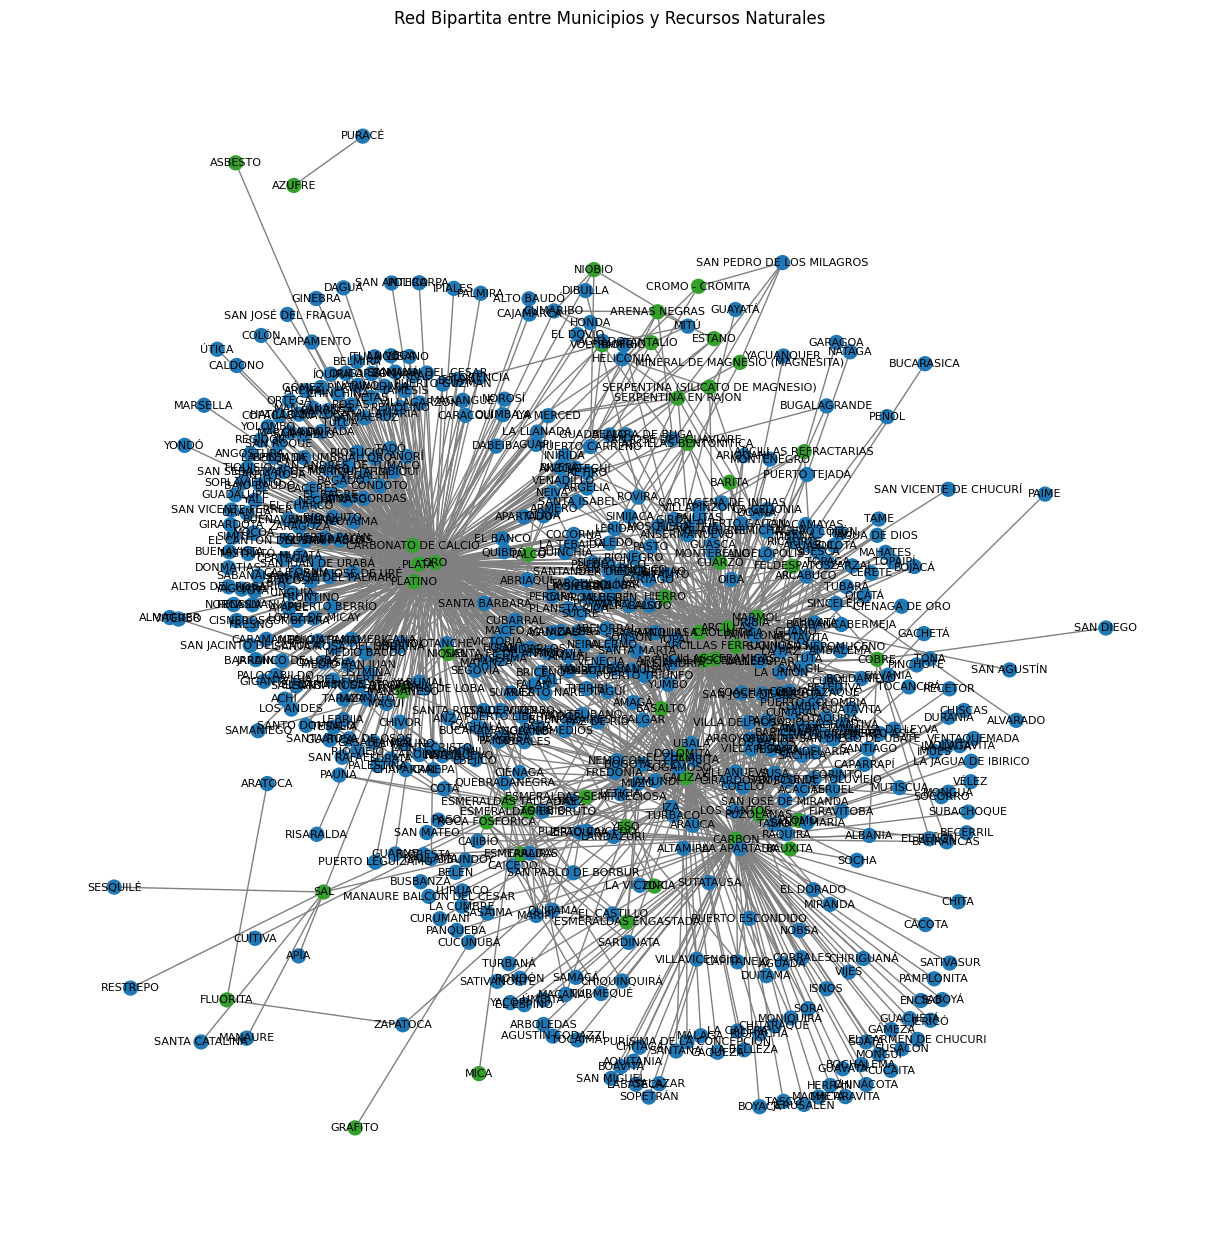

In [14]:
def plot_bipartite_graph(B):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(B, k=0.1, iterations=20)
    nx.draw(B, pos, with_labels=True, 
            node_color=['#1f78b4' if B.nodes[node]['bipartite'] == 0 else '#33a02c' for node in B.nodes()],
            node_size=100, edge_color='gray', font_size=8)
    plt.title('Red Bipartita entre Municipios y Recursos Naturales')
    plt.show()

plot_bipartite_graph(B)

### 5. Redes de Coocurrencia

Creamos redes de coocurrencia que representan la frecuencia con que entidades aparecen juntas:


In [15]:
def create_cooccurrence_graph(df, group_by, other_entity):
    cooccurrence = nx.Graph()
    groups = defaultdict(list)

    for _, row in df.iterrows():
        groups[row[group_by]].append(row[other_entity])

    for entities in groups.values():
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                entity1, entity2 = entities[i], entities[j]
                if cooccurrence.has_edge(entity1, entity2):
                    cooccurrence[entity1][entity2]['weight'] += 1
                else:
                    cooccurrence.add_edge(entity1, entity2, weight=1)

    return cooccurrence

coocurrencia_recursos = create_cooccurrence_graph(df, 'municipio', 'recurso_natural')
coocurrencia_municipios = create_cooccurrence_graph(df, 'recurso_natural', 'municipio')


### 6. Guardar Resultados

Guardamos las redes generadas en formato GraphML para futuros análisis.


In [17]:
def save_graph(G, file_path):
    nx.write_graphml(G, file_path)

save_graph(B, '../datos/processed/red_bipartita_municipios_recursos.graphml')
save_graph(coocurrencia_recursos, '../datos/processed/coocurrencia_recursos.graphml')
save_graph(coocurrencia_municipios, '../datos/processed/coocurrencia_municipios.graphml')


Con estos pasos, hemos generado y visualizado redes bipartitas y de coocurrencia, proporcionando insights sobre la explotación de minerales en Colombia.


In [18]:
# Calcular centralidad de grado
grado_centralidad = nx.degree_centrality(coocurrencia_municipios)

# Calcular centralidad de cercanía
cercania_centralidad = nx.closeness_centrality(coocurrencia_municipios)

# Calcular centralidad de intermediación
intermediacion_centralidad = nx.betweenness_centrality(coocurrencia_municipios)

# Calcular centralidad de eigenvector
eigenvector_centralidad = nx.eigenvector_centrality(coocurrencia_municipios)

# Mostrar las 5 principales entidades según cada medida de centralidad
print("Top 5 entidades por Centralidad de Grado:", sorted(grado_centralidad.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 entidades por Centralidad de Cercanía:", sorted(cercania_centralidad.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 entidades por Centralidad de Intermediación:", sorted(intermediacion_centralidad.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 entidades por Centralidad de Eigenvector:", sorted(eigenvector_centralidad.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 entidades por Centralidad de Grado: [('YUMBO', 0.9212454212454212), ('VENECIA', 0.8534798534798534), ('TITIRIBÍ', 0.8516483516483516), ('EL TAMBO', 0.8516483516483516), ('CALI', 0.8443223443223443)]
Top 5 entidades por Centralidad de Cercanía: [('YUMBO', 0.9220370025454772), ('VENECIA', 0.8676265255212623), ('TITIRIBÍ', 0.8662449546207508), ('EL TAMBO', 0.8662449546207508), ('CALI', 0.860762391616822)]
Top 5 entidades por Centralidad de Intermediación: [('MONTELÍBANO', 0.01696346356181993), ('YUMBO', 0.016886288621494577), ('VENECIA', 0.01197790787182711), ('TITIRIBÍ', 0.011897175942941181), ('EL TAMBO', 0.011897175942941181)]
Top 5 entidades por Centralidad de Eigenvector: [('YUMBO', 0.06746178268744338), ('VENECIA', 0.06605215239453212), ('TITIRIBÍ', 0.06604472207049024), ('EL TAMBO', 0.06604472207049024), ('CALI', 0.0657507758962195)]
